In [1]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device",jax.devices()[2])
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# from KernelTools import *
from parabolic_data_utils import (
    build_burgers_data,
    build_tx_grid_chebyshev,
)

In [2]:
k = 5e-4
kappa = 0.01
alpha = 0.5
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0

u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

  0%|          | 0/10099 [00:00<?, ?it/s]

## Compute collocation points, insert sample points

In [3]:
num_grid_x = 26
num_grid_t = 26

#Build a collocation grid
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.6)

tx_all = jnp.vstack([tx_bdy,tx_int])

#Observe on initial+final+boundary
init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)
final_obs_inds = jnp.where(tx_int[:,0]==1)[0][::1]
u_true = u_true_function(tx_all)

x_t_sample_inds = jnp.hstack([init_obs_inds,final_obs_inds])
tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])
u_obs = u_true_function(tx_obs)


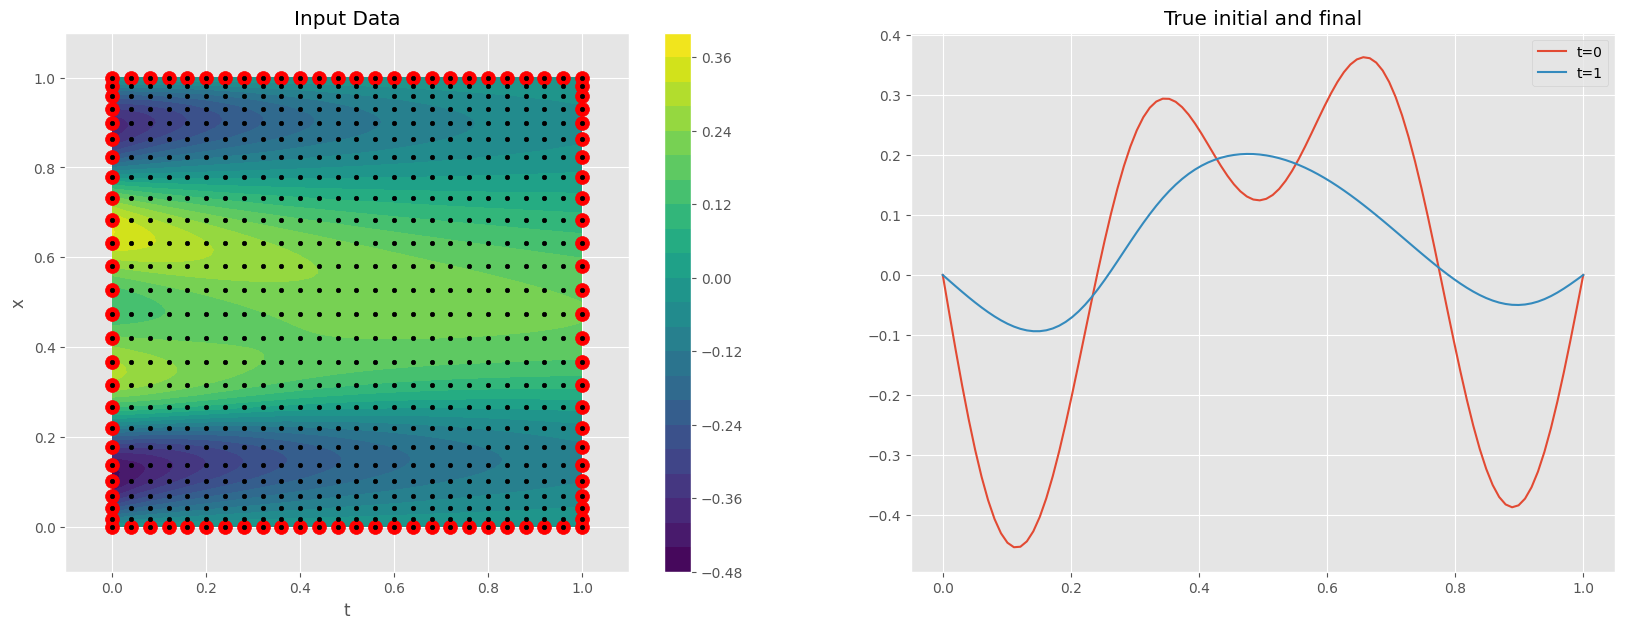

In [4]:
num_fine_grid = 100
final_time = 1
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 10)
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Input Data")

plt.subplot(1,2,2)
plt.title("True initial and final")
grid_points = jnp.linspace(0,1,num_fine_grid)
plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid),grid_points]).T),label = 't=0')
plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine_grid),grid_points]).T),label = 't=1')
plt.legend()
plt.show()


## Setup model

In [40]:
from EquationModel import CholInducedRKHS, OperatorPDEModel,OperatorModel
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_gaussianRBF,
    get_anisotropic_gaussianRBF
)
from KernelTools import eval_k,dx_k,dxx_k,dt_k


u_operators = (eval_k,dx_k,dt_k,dxx_k)
feature_operators = (eval_k,dx_k,dxx_k)

k_u = get_gaussianRBF(jnp.sqrt(0.025/2))
# k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(jnp.array([1.,100])))

u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')

from KernelTools import vectorize_kfunc
@vectorize_kfunc
def k_P(x,y):
    return 10*k_P_u_part(x[2:],y[2:])

P_model = OperatorModel(k_P)
    

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100,
    jacobian_operator = jax.jacrev
)

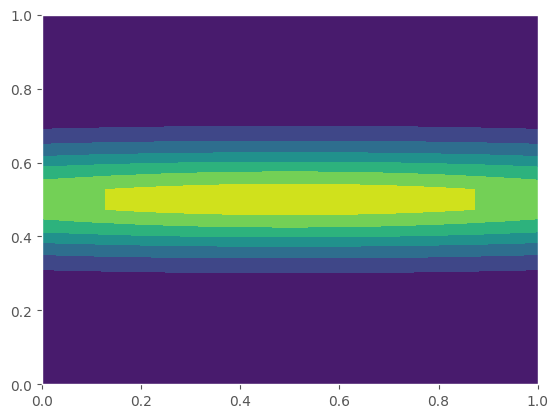

In [41]:
plt.tricontourf(tx_all[:,0],tx_all[:,1],vectorize_kfunc(k_u)(jnp.array([[0.5,0.5]]),tx_all)[0])

In [42]:
import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import (
    CholeskyLM,SVD_LM,LMParams,plot_optimization_results
)

optParams = LMParams(
    max_iter = 251,init_alpha = 0.05,min_alpha = 1e-16,show_progress=True)

params_init = jnp.hstack([u_params_init,jnp.zeros(EqnModel.num_operator_params)])

params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 0.,
    optParams=optParams
)
svd_params = LMParams(
    max_iter=201,
    init_alpha=convergence_data.alpha_vals[-1],
    min_alpha=1e-16,print_every=50,
    step_adapt_multiplier=1.6)


p_adjusted,refine_convergence_data = SVD_LM(params,EqnModel,beta = 1e-16,optParams=svd_params)

  0%|          | 0/251 [00:00<?, ?it/s]

Iteration 0, loss = 0.003497, gradnorm = 204.0, alpha = 0.04167, improvement_ratio = 0.9758
Iteration 1, loss = 0.002568, gradnorm = 42.95, alpha = 0.03472, improvement_ratio = 0.9672
Iteration 2, loss = 0.002109, gradnorm = 13.55, alpha = 0.02894, improvement_ratio = 0.9861
Iteration 3, loss = 0.001768, gradnorm = 3.75, alpha = 0.02411, improvement_ratio = 0.9864
Iteration 4, loss = 0.001491, gradnorm = 4.205, alpha = 0.02009, improvement_ratio = 0.9883
Iteration 5, loss = 0.001263, gradnorm = 4.458, alpha = 0.01674, improvement_ratio = 0.9958
Iteration 50, loss = 3.597e-05, gradnorm = 0.1868, alpha = 4.579e-06, improvement_ratio = 0.9949
Iteration 100, loss = 3.147e-06, gradnorm = 0.08416, alpha = 1.132e-09, improvement_ratio = 0.9979
Iteration 150, loss = 1.949e-06, gradnorm = 0.00317, alpha = 9.307e-10, improvement_ratio = 0.9995
Iteration 200, loss = 1.837e-06, gradnorm = 0.0001214, alpha = 7.651e-10, improvement_ratio = 0.9997
Iteration 250, loss = 1.779e-06, gradnorm = 0.0002897

  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 1.778e-06, gradnorm = 0.0001248, alpha = 5.897e-10, improvement_ratio = 0.9999
Iteration 1, loss = 1.776e-06, gradnorm = 4.699e-06, alpha = 3.686e-10, improvement_ratio = 0.9999
Iteration 2, loss = 1.774e-06, gradnorm = 9.432e-06, alpha = 2.304e-10, improvement_ratio = 0.9999
Iteration 3, loss = 1.77e-06, gradnorm = 2.048e-05, alpha = 1.44e-10, improvement_ratio = 0.9999
Iteration 4, loss = 1.764e-06, gradnorm = 4.418e-05, alpha = 8.999e-11, improvement_ratio = 0.9998
Iteration 5, loss = 1.755e-06, gradnorm = 9.609e-05, alpha = 5.624e-11, improvement_ratio = 0.9997
Iteration 50, loss = 3.192e-07, gradnorm = 0.009517, alpha = 1.819e-14, improvement_ratio = 0.6865
Iteration 100, loss = 2.809e-07, gradnorm = 0.01206, alpha = 1.689e-14, improvement_ratio = 0.3101
Iteration 150, loss = 2.715e-07, gradnorm = 0.001216, alpha = 1.784e-14, improvement_ratio = 0.5964
Iteration 200, loss = 2.685e-07, gradnorm = 0.01082, alpha = 1.256e-14, improvement_ratio = 0.7295


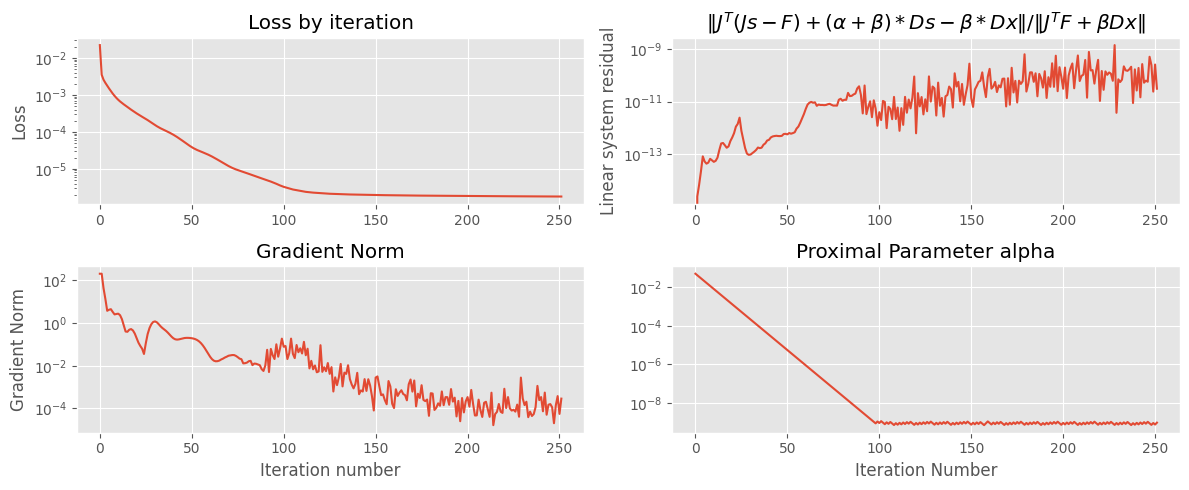

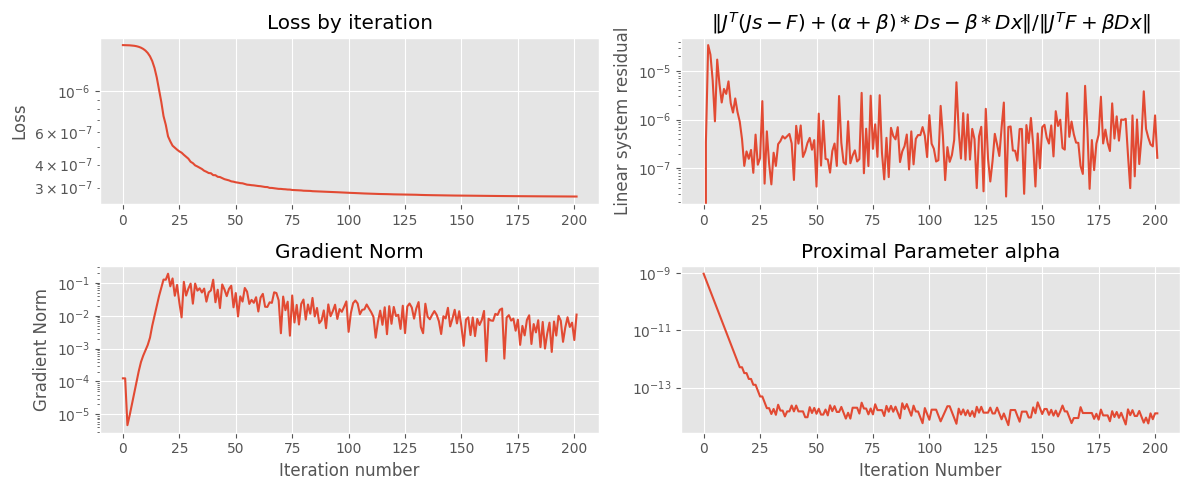

In [43]:
plot_optimization_results(convergence_data)
plot_optimization_results(refine_convergence_data)

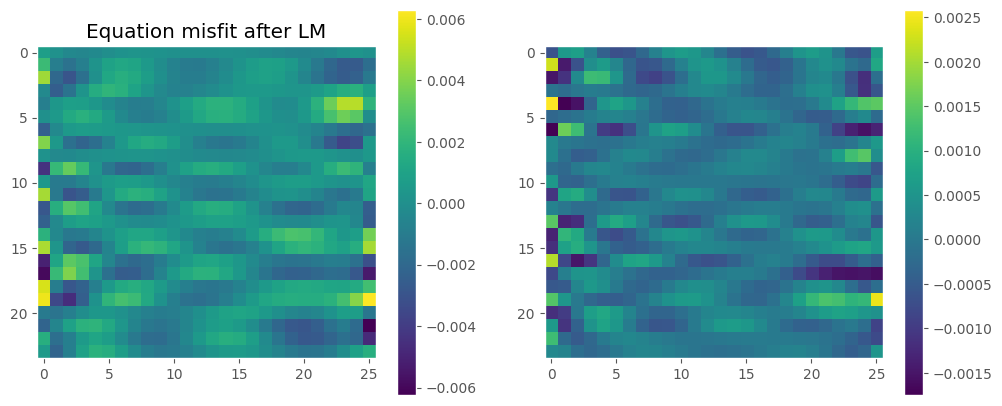

Pre Refinement  2.353027493904873e-06
Post Refinement  2.9161945923723456e-07


In [44]:
equation_residuals = EqnModel.stacked_equation_residual(
    EqnModel.get_u_params(params),EqnModel.get_P_params(params)
    )

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Equation misfit after LM")
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t)[::-1])
plt.grid(None)
plt.colorbar()
plt.subplot(1,2,2)

equation_residuals_refined = EqnModel.stacked_equation_residual(
    EqnModel.get_u_params(p_adjusted),EqnModel.get_P_params(p_adjusted)
    )
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()
print("Pre Refinement ",jnp.mean(equation_residuals**2))
print("Post Refinement ",jnp.mean(equation_residuals_refined**2))

,NRMSE,NMAE
1 Step,0.035422,0.031213
2 Step,0.299785,0.269276


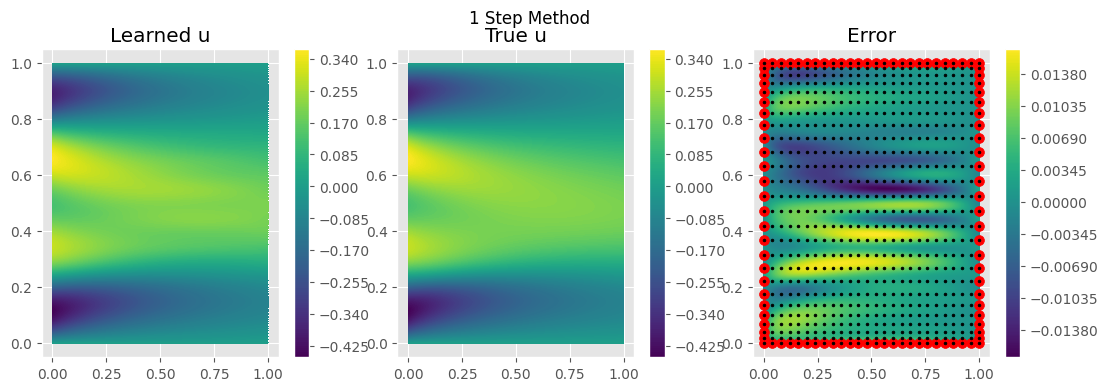

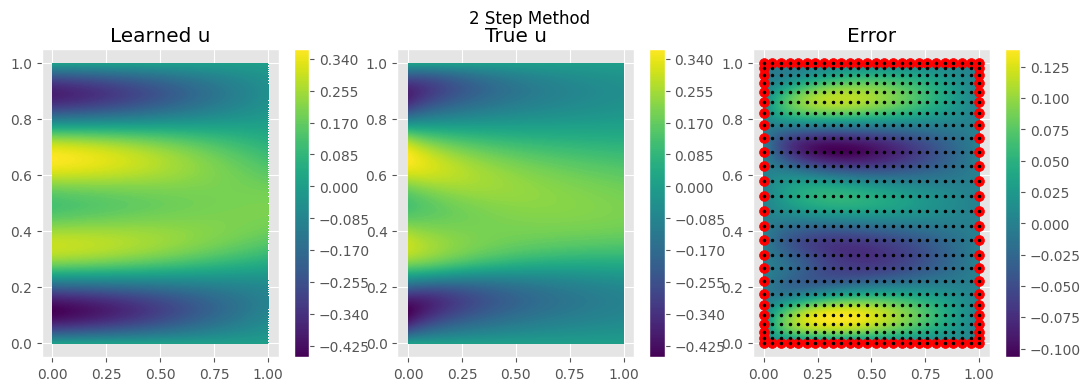

In [45]:
from evaluation_metrics import get_nrmse,get_nmae,compute_results
from plotting import plot_input_data,plot_compare_error

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

# u_sol = params[:u_model.num_params]
# P_sol = params[u_model.num_params:]


num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)
u_true_fine = u_true_function(tx_grid_fine)

display(compute_results(
    u_true_fine,
    {
        "1 Step":u_eval_fine,
        "2 Step":u_model.point_evaluate(tx_grid_fine,u_params_init),
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
))

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_sol),u_true_function,title= "1 Step Method"
)

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_params_init),u_true_function,title = "2 Step Method"
)